## 文本分类

本文主要介绍了使用Python对文本数据进行处理与建模的过程。整个分析过程比较简单，主要包括:  

- 观察词频，选取词频高的词作为文本特征
- 生成document-term矩阵
- tf-idf变换
- 训练文本分类模型

通过这些分析，建立文本分类模型  
本文的代码和使用的数据可以在[github](https://github.com/snowhyzhang/yukino/tree/master/nlp)上找到

### 配置分词器

使用`jieba`分词器进行分词。在这里扩展了分词器的配置，增加了停用词、保留目标词以及保留具有目标词性的词。

In [1]:
import re
import jieba.posseg as pseg

# 读入停用词
stopwords = set()
with open('dict/stopwords.utf8.txt') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.add(word)


# 配置目标词性，只保留名词
def require_tag_func(tag):
    return re.search(r'^n.*', tag)


class ChineseTokenizer():
    def __init__(self, stopwords=None, retain_words=None, require_tag_func=None):
        """
        配置分词器
        
        :param stopwords: 停用词
        :param retain_words: 保留词
        :param require_tag_func: 配置符合要求词性的函数
        """
        self.stopwords = stopwords
        self.retain_words = retain_words
        self.require_tag_func = require_tag_func
        self.is_check_word = self._is_check_word()
        
    def _is_check_word(self):
        return self.stopwords is not None or \
                self.require_tag_func is not None or \
                self.retain_words is not None
        
    def is_valid_word(self, word_tag):
        word, tag = word_tag
        word = word.strip()
        if len(word) == 0 or (self.stopwords is not None and word in self.stopwords):
            return False
        if self.require_tag_func is not None and not self.require_tag_func(tag):
            return False
        if self.retain_words is not None and not word in self.retain_words:
            return False
        return True
    
    def tokenize(self, s):
        words = pseg.cut(s)
        if self.is_check_word:
            words = filter(lambda x: self.is_valid_word(x), words)
        words = [word for word, _ in words]
        return words
    
    def __call__(self, doc):
        return self.tokenize(doc)

chn_tokenizer = ChineseTokenizer(stopwords=stopwords, require_tag_func=require_tag_func)

### 语料探索

使用`ntlk`来读取语料库

In [2]:
from nltk.corpus import PlaintextCorpusReader

corpus_dir = 'data/'
wordlists = PlaintextCorpusReader(corpus_dir, '.*\.txt', 
                                  # 语料库编码
                                  encoding='GB18030', 
                                  # 分词器，必须实现tokenize方法
                                  word_tokenizer=chn_tokenizer)
wordlists.fileids()[:5]

['C32-Agriculture/C32-Agriculture0002.txt',
 'C32-Agriculture/C32-Agriculture0003.txt',
 'C32-Agriculture/C32-Agriculture0005.txt',
 'C32-Agriculture/C32-Agriculture0007.txt',
 'C32-Agriculture/C32-Agriculture0009.txt']

处理文件名称和文件类别

In [3]:
import pandas as pd

file_cat = []
for fileid in wordlists.fileids():
    category = fileid.split('/')[0].split('-')[1]
    file_cat.append((fileid, category))
    
file_pd = pd.DataFrame(file_cat, columns=['file', 'category'])
file_pd['category'] = pd.Categorical(file_pd['category'])
file_pd.iloc[:5]

,file,category
0,C32-Agriculture/C32-Agriculture0002.txt,Agriculture
1,C32-Agriculture/C32-Agriculture0003.txt,Agriculture
2,C32-Agriculture/C32-Agriculture0005.txt,Agriculture
3,C32-Agriculture/C32-Agriculture0007.txt,Agriculture
4,C32-Agriculture/C32-Agriculture0009.txt,Agriculture


切分训练集与测试集

In [4]:
from sklearn.model_selection import train_test_split

files = file_pd['file']
categories = file_pd['category']

files_train, files_test, y_train, y_test = train_test_split(files, categories, test_size=0.3, 
                                                            stratify=categories, random_state=1024)

计算词频，选取高频词汇作为文本特征

In [5]:
import nltk

freq_dist = nltk.FreqDist(word for fileid in wordlists.fileids() if fileid in set(files_train) 
                          for word in wordlists.words(fileid))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/24/5z49fxqn0zx_9ymk936f_9t00000gn/T/jieba.cache
Loading model cost 0.912 seconds.
Prefix dict has been built succesfully.


In [6]:
freq_dist.most_common(10)

[('农业', 38326),
 ('中国', 13338),
 ('经济', 12558),
 ('历史', 12056),
 ('社会', 11825),
 ('人', 11111),
 ('问题', 9447),
 ('学生', 8269),
 ('市场', 7634),
 ('技术', 7607)]

选取前2000个词作为文本特征

In [7]:
freq_words = [word for word, _ in freq_dist.most_common(2000)]
freq_words[-10:]

['布尔加科夫', '企', '市场调节', '纪录', '院', '师范学校', '修正', '工艺', '天地', '殷']

### 模型

#### 数据预处理

定义只保留2000个词作为特征的分词器

In [8]:
chn_tokenizer_common = ChineseTokenizer(retain_words=set(freq_words))

使用`scikit-learn`的`CountVectorizer`建立Document-Term矩阵

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(tokenizer=chn_tokenizer_common)

读入训练语料

In [10]:
root_dir = 'data/'
train_contents = []

for file in files_train:
    file_path = root_dir + file
    with open(file_path, encoding='GB18030') as f:
        train_contents.append(f.read())
print(train_contents[0][:30])

【 文献号 】3-659
【原文出处】宁德师专学报：哲社版



In [11]:
X_train = count_vectorizer.fit_transform(train_contents)

`tf-idf`变换

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)

读入测试语料

In [13]:
test_contents = []

for file in files_test:
    file_path = root_dir + file
    with open(file_path, encoding='GB18030') as f:
        test_contents.append(f.read())

处理测试集数据

In [14]:
X_test = count_vectorizer.transform(test_contents)
X_test_tfidf = tfidf_transformer.transform(X_test)

#### 朴素贝叶斯模型

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

nb_predict = nb_clf.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predict)
round(nb_accuracy, 4)

0.9631

#### 随机森林模型

In [16]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

# 决策树使用信息增益
rf = RandomForestClassifier(criterion='entropy')
rf_params = [{'n_estimators': [500, 750, 1000]}]
cv = KFold(n_splits=10, shuffle=True, random_state=1024)

rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=cv)

rf_clf.fit(X_train_tfidf, y_train)

rf_predict = rf_clf.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predict)
round(rf_accuracy, 4)

0.9594

#### SVM模型

In [17]:
from sklearn.svm import SVC

svm = SVC()
svm_params = [{'C': [10**i for i in range(-3, 4)]}]

svm_clf = GridSearchCV(estimator=svm, param_grid=svm_params, cv = cv)

svm_clf.fit(X_train_tfidf, y_train)

svm_predict = rf_clf.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_predict)
round(svm_accuracy, 4)

0.9594

<IPython.core.display.Javascript object>


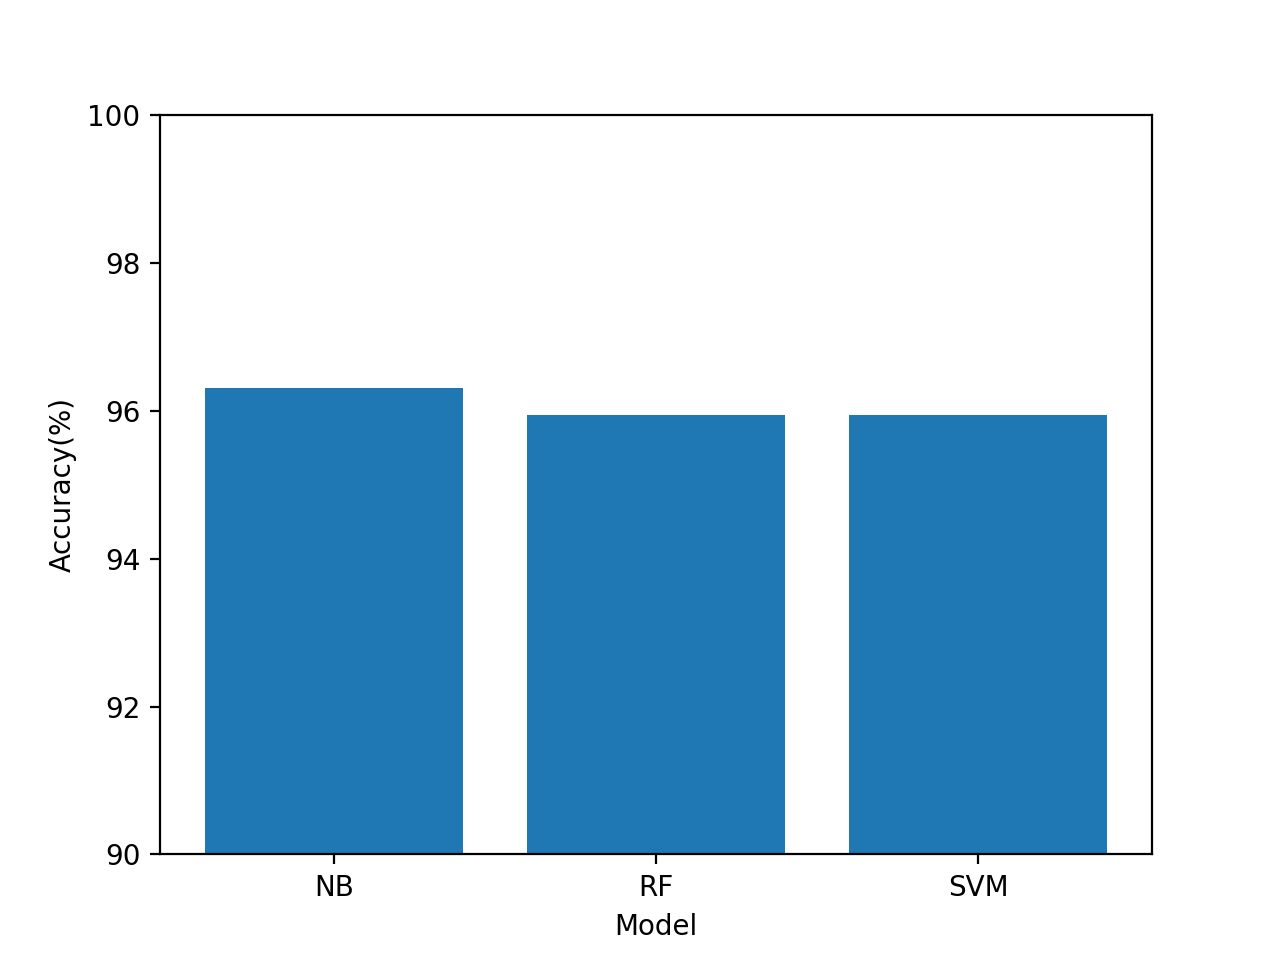

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.bar(['NB', 'RF', 'SVM'], [round(acc * 100, 2) for acc in (nb_accuracy, rf_accuracy, svm_accuracy)], 
        width=0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy(%)')
plt.ylim([90, 100])
plt.show()